## Experiment 0: Spectrum of the cov matrix and information loss

In [1]:
import torch
from gp import *

In [2]:
def safe_projection(K, W, jitter_scale=1e-6):
    """
    Compute K - K W (W^T K W)^(-1) W^T K safely.

    K: (N,N) Gram matrix
    W: (N,M) projection matrix
    """
    KW = K @ W          # (N, M)
    WTK = W.T @ K       # (M, N)
    A = W.T @ KW        # (M, M)

    # scale jitter relative to A
    eps = jitter_scale * np.trace(A) / A.shape[0]
    A += eps * np.eye(A.shape[0])

    # Cholesky solve
    L = np.linalg.cholesky(A)                  # A = L L^T
    X = np.linalg.solve(L.T, np.linalg.solve(L, WTK))  # A^{-1} W^T K

    result = K - KW @ X
    return result



def plot_sorted_eigenvalues_list(matrices, labels, title="Eigenvalue Spectra"):
    """
    Plot sorted eigenvalues (decreasing) of multiple matrices on a semilog-x plot.

    - First matrix: gold, thicker line, legend in a box (top right).
    - Remaining matrices: dodgerblue, thinner lines, labeled at x=1 above the line.

    Parameters
    ----------
    matrices : list of np.ndarray
        List of square matrices.
    labels : list of str
        Labels corresponding to each matrix.
    title : str
        Title of the plot.
    """
    if len(matrices) != len(labels):
        raise ValueError("Number of matrices and labels must match.")

    plt.figure(figsize=(4, 2.5))

    for i, (matrix, label) in enumerate(zip(matrices, labels)):
        eigvals = np.sort(np.linalg.eigvals(matrix).real)[::-1]
        x = np.arange(1, len(eigvals) + 1)  # start at 1 for log scale

        if i == 0:
            # First matrix highlighted
            plt.semilogx(x, eigvals, color="gold", linewidth=2.5, label=r'Spectrum of $K_\mathbf{x}$')
        elif  i == 1:
            # Remaining matrices
            line, = plt.semilogx(x, eigvals, color="dodgerblue", linewidth=1.2, label  = r'Spectrum of $\Sigma_{\mathbf{y}|\mathbf{z}}$')
            # Label at x=1 just above the line
            plt.text(1, eigvals[0] * 1.02, label,
                     color="dodgerblue", fontsize=9,
                     ha="left", va="bottom")
            
        else:
            # Remaining matrices
            line, = plt.semilogx(x, eigvals, color="dodgerblue", linewidth=1.2)
            # Label at x=1 just above the line
            plt.text(1, eigvals[0] * 1.02, label,
                     color="dodgerblue", fontsize=9,
                     ha="left", va="bottom")

    # Apply requested labels
    plt.xlabel(None)
    plt.ylabel("eigenvalues")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.6, which="both")

    # Boxed legend only for the first curve
    plt.legend(loc="upper right", frameon=True, fancybox=True)

    plt.savefig(f"img/directions-{title}.pdf", bbox_inches='tight', pad_inches=0)


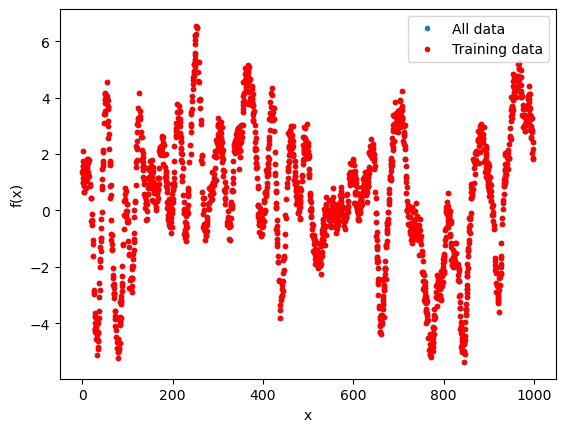

In [3]:
n_data = 2000
n_train = 2000
X = 1000*torch.rand(n_data,1)
hypers = [5, 10, 0.1]
gp_true = GP(hypers = hypers)
y = gp_true.sample_from_prior(X)
#y = y.squeeze()    # make sure it’s 1D

X_data = X.detach().cpu()
y_data = y.detach().cpu()

idx = torch.randperm(n_data)[:n_train]
# subset of the data

X_train = X_data[idx]
y_train = y_data[idx]

X_train = X_data
y_train = y_data

plt.plot(X_data, y_data, '.', label="All data")
plt.plot(X_train, y_train, 'r.', label="Training data")
plt.legend()

plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

In [4]:
K = gp_true.kernel_mat_self(X, add_noise=False)
K = K.detach().cpu().numpy()
KI = gp_true.kernel_mat_self(X, add_noise=True)
KI = KI.detach().cpu().numpy()

labels_list = ['original', 'k=50', 'k=100', 'k=200']

In [5]:
gp_proj = GP(X_train, y_train, kernel = 'SE', M=50, method = 'proj-sphere')
W50 = gp_proj.w
gp_proj = GP(X_train, y_train, kernel = 'SE', M=100, method = 'proj-sphere')
W100 = gp_proj.w
gp_proj = GP(X_train, y_train, kernel = 'SE', M=200, method = 'proj-sphere')
W200 = gp_proj.w


In [6]:
res50 = safe_projection(K,W50, jitter_scale=0.001)
res100 = safe_projection(K,W100, jitter_scale=0.001)
res200 = safe_projection(K,W200, jitter_scale=0.01)

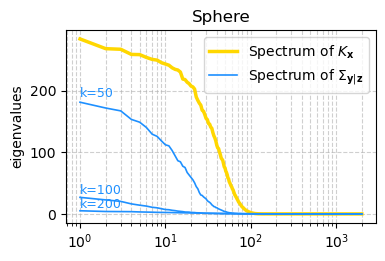

In [7]:
ax = plot_sorted_eigenvalues_list([K, res50, res100, res200], labels_list, title = 'Sphere')



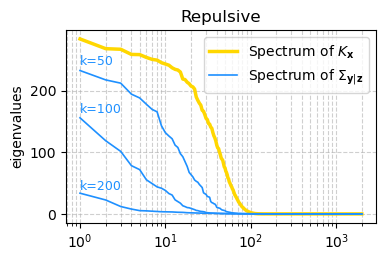

In [8]:
gp_proj = GP(X_train, y_train, kernel = 'SE', M=50, method = 'proj-repulsive')
W50 = gp_proj.w
gp_proj = GP(X_train, y_train, kernel = 'SE', M=100, method = 'proj-repulsive')
W100 = gp_proj.w
gp_proj = GP(X_train, y_train, kernel = 'SE', M=200, method = 'proj-repulsive')
W200 = gp_proj.w

res50 = safe_projection(K,W50, jitter_scale=0.001)
res100 = safe_projection(K,W100, jitter_scale=0.001)
res200 = safe_projection(K,W200, jitter_scale=0.01)

ax = plot_sorted_eigenvalues_list([K, res50, res100, res200], labels_list, title = 'Repulsive')


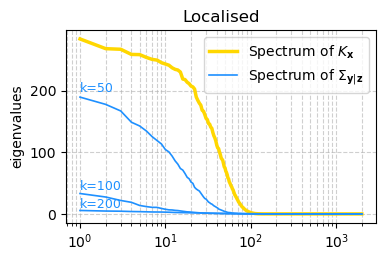

In [9]:
gp_proj = GP(X_train, y_train, kernel = 'SE', M=50, method = 'proj-localised')
W50 = gp_proj.w
gp_proj = GP(X_train, y_train, kernel = 'SE', M=100, method = 'proj-localised')
W100 = gp_proj.w
gp_proj = GP(X_train, y_train, kernel = 'SE', M=200, method = 'proj-localised')
W200 = gp_proj.w

res50 = safe_projection(K,W50, jitter_scale=0.001)
res100 = safe_projection(K,W100, jitter_scale=0.001)
res200 = safe_projection(K,W200, jitter_scale=0.01)

ax = plot_sorted_eigenvalues_list([K, res50, res100, res200], labels_list, title = 'Localised')


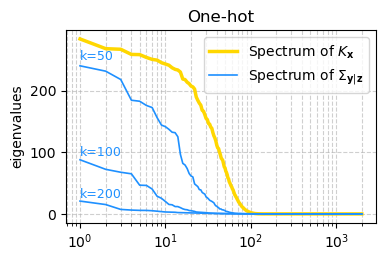

In [10]:
gp_proj = GP(X_train, y_train, kernel = 'SE', M=50, method = 'proj-onehot')
W50 = gp_proj.w
gp_proj = GP(X_train, y_train, kernel = 'SE', M=100, method = 'proj-onehot')
W100 = gp_proj.w
gp_proj = GP(X_train, y_train, kernel = 'SE', M=200, method = 'proj-onehot')
W200 = gp_proj.w

res50 = safe_projection(K,W50, jitter_scale=0.001)
res100 = safe_projection(K,W100, jitter_scale=0.001)
res200 = safe_projection(K,W200, jitter_scale=0.01)

ax = plot_sorted_eigenvalues_list([K, res50, res100, res200], labels_list, title = 'One-hot')
